# **RADI623: Natural Language Processing**

### Assignment: Natural Language Processing
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/NLP-Medical-Specialty-Classification)

## **Medical Specialty Identification**

The problem of predicting one’s illnesses wrongly through self-diagnosis in medicine is very real. In a report by the [Telegraph](https://www.telegraph.co.uk/news/health/news/11760658/One-in-four-self-diagnose-on-the-internet-instead-of-visiting-the-doctor.html), nearly one in four self-diagnose instead of visiting the doctor. Out of those who misdiagnose, nearly half have misdiagnosed their illness wrongly [reported](https://bigthink.com/health/self-diagnosis/). While there could be multiple root causes to this problem, this could stem from a general unwillingness and inability to seek professional help.

Elevent percent of the respondents surveyed, for example, could not find an appointment in time. This means that crucial time is lost during the screening phase of a medical treatment, and early diagnosis which could have resulted in illnesses treated earlier was not achieved.

With the knowledge of which medical specialty area to focus on, a patient can receive targeted help much faster through consulting specialist doctors. To alleviate waiting times and predict which area of medical specialty to focus on, we can utilize natural language processing (NLP) to solve this task.

Given any medical transcript or patient condition, this solution would predict the medical specialty that the patient should seek help in. Ideally, given a sufficiently comprehensive transcript (and dataset), one would be able to predict exactly which illness he is suffering from.

### Import the relevant libraries

In [18]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import logging
import random
import os
import itertools
import copy
import time
import warnings 
warnings.filterwarnings('ignore')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.pipeline.tagger import Tagger
from spacy.language import Language
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel, BertTokenizer, DistilBertModel
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

import transformers
from time import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
from transformers import RobertaModel
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer)
from tokenizers import BertWordPieceTokenizer
from transformers import PreTrainedTokenizerFast
from transformers import BertTokenizerFast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Prior to NLP task, we first ensured a deterministic behavior of our simulations by setting the seed value for various random number generators in order to obtain consistent results and facilitate reproducibility in the execution of the code. The <code>set_seed</code> function was directly copied from the Professor's lecture codes.

In [3]:
def set_seed(seed):
    if seed:
        logging.info(f'Running in deterministic mode with seed {seed}')
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info('Running in non-deterministic mode')
set_seed(1997)

### <code>Question 1</code>. Conduct an exploratory data analysis on the dataset.  Report the corpus statistics with appropriate visualization.  Explain clearly why the selected visualization fits your purpose.  

Let's first explore the dataset first! The dataset, <code>mtsamples.csv</code>, consists of 4999 samples (rows) with 5 features (columns) - namely <code>description, medical_specialty, sample_name, transcription, and keywords.</code> Since this is a text classification task, the <code>medical_specialty</code> serves as the labels of the dataset. There are 40 unique <code>medical_specialty</code> in the original dataset, leading to a multiclass classification. Some of the labels include Allergy/Immunology, Bariatrics, Cardiovascular/Pulmonary, and General Medicine. There are labels, however, that are not directly related to medical specialties, including Letters, Office Notes, and SOAP/Chart/Progress Notes. 

In [4]:
data = pd.read_csv('../data/mtsamples.csv')

num_samples = len(data)
num_medical_specialties = data['medical_specialty'].nunique()

print(f'Number of samples in the original dataset: \t {num_samples}')
print(f'Number of unique labels in the original dataset: {num_medical_specialties}')

Number of samples in the original dataset: 	 4999
Number of unique labels in the original dataset: 40


In the code below, we created functions that can help us to understand the nature of the given dataset. The function <code>calculate_univariate</code> takes a <code>data</code> parameter to display the univariate characteristics of the <code>transcription</code> and <code>description</code>. Specifically, the <code>data</code> parameter should be a DataFrame that contains the columns: <code>transcription</code> and <code>description</code>. This code calculates various statistical measures (average, minimum, maximum) for the lengths of the <code>transcription</code> and <code>description</code> strings in the input data and returns the results in a dictionary format.

The function <code>plot_classes</code> takes a <code>data</code> parameter, assumed to be a DataFrame, that can generate a bar plot to visualize the distribution of medical specialties in the input data. This function will be useful to visualize how many samples exist in the dataset for every class (i.e., class distribution). The x-axis represents the medical specialties while the y-axis represents the frequency counts.

Similar to previous functions, the <code>plot_histogram</code> takes a DataFrame <code>data</code> parameter that can generate a histogram plot to visualize the distribution of the lengths of the <code>transcription</code> and <code>description</code> values in the input data.

In [9]:
def calculate_univariate(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    avg_description_length = description_lengths.mean()
    min_description_length = description_lengths.min()
    max_description_length = description_lengths.max()

    avg_transcription_length = transcription_lengths.mean()
    min_transcription_length = transcription_lengths.min()
    max_transcription_length = transcription_lengths.max()

    dictionary = {}
    dictionary['description']   = [avg_description_length, min_description_length, max_description_length]
    dictionary['transcription'] = [avg_transcription_length, min_transcription_length, max_transcription_length]
    return dictionary
summary = calculate_univariate(data)

def plot_classes(data):
    specialty_counts = data['medical_specialty'].value_counts()

    plt.figure(figsize = (12, 5))
    plt.bar(specialty_counts.index, specialty_counts.values)
    plt.xlabel('Medical Specialty')
    plt.ylabel('Frequency')
    plt.title('Distribution of Medical Specialties')
    plt.xticks(rotation = 90)
    plt.show()

def plot_histogram(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(description_lengths, bins=50, alpha=0.8)
    axs[0].set_xlabel('Description Length')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Description Lengths')

    axs[1].hist(transcription_lengths, bins = 50, alpha = 0.8)
    axs[1].set_xlabel('Transcription Length')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Transcription Lengths')
    plt.tight_layout()
    plt.show()

The dataset exhibits a significant imbalance in terms of document distribution across medical specialties. <code>Surgery</code> stands out as the most frequent specialty, comprising 1088 documents, while <code>Hospice - Palliative Care</code> has the lowest representation with a mere 6 documents. This discrepancy in frequencies indicates a clear imbalance, where there is a substantial over-representation of documents related to <code>Surgery</code> compared to other specialties, such as <code>Hospice - Palliative Care</code>. Such data imbalances can pose challenges in training accurate and fair machine learning models, as the model may be biased towards the majority class and struggle to generalize well to minority classes.

To rectify this imbalance, several techniques can be employed. One common approach is oversampling or undersampling. Oversampling involves duplicating instances from the minority class to increase its representation, while undersampling involves removing instances from the majority class to reduce its dominance. Another technique is generating synthetic samples using methods like Synthetic Minority Over-sampling Technique (SMOTE), which creates new instances by interpolating between existing minority class samples. Additionally, techniques like stratified sampling during train-test splitting or cross-validation can ensure that each subset maintains the original class distribution. *We can rectify this problem later.*

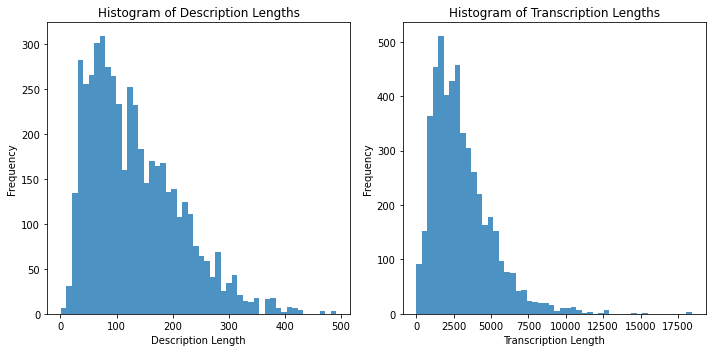

In [6]:
plot_histogram(data)

The function <code>get_sentence_word_count</code> takes a list of texts as input and calculates the total number of sentences and unique words within the given texts. It achieves this by tokenizing the texts into sentences and words, and then iteratively counting the sentences and updating a vocabulary dictionary. The number of sentences provides an understanding of the overall length and complexity of the text. This can be useful for determining the granularity of text classification, similar to this project. Moreover, the number of unique words represents the vocabulary size of the text data. This indicates the diversity and richness of the language used in the transcriptions. Larger vocabulary sizes can be indicative of more varied topics or specialized domain-specific terminology. This code is valuable for gaining insights into the text data found in the <code>transcriptions</code> column. By determining the sentence count and word count, it provides an understanding of the text's structure and lexical richness. 

**The results obtained from the code indicate that there are 140,208 sentences and 35,805 unique words in the <code>transcriptions</code> column of the text data. Since this dataset contains a large number fo sentences, models such as Transformers can be a viable choice since they can handle large sequential data.**

In [7]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences  = sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words  = word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] = 1 
    word_count = len(vocab.keys())
    return sent_count,word_count

clinical_text_df = data[data['transcription'].notna()]
sent_count, word_count = get_sentence_word_count(clinical_text_df['transcription'].tolist())

print('Number of sentences in transcriptions column: '    + str(sent_count))
print('Number of unique words in transcriptions column: ' + str(word_count))

Number of sentences in transcriptions column: 140208
Number of unique words in transcriptions column: 35805


In [8]:
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
sent_count, word_count = get_sentence_word_count(filtered_data_categories['transcription'].tolist())

print('Number of sentences in transcriptions column: '    + str(sent_count))
print('Number of unique words in transcriptions column: ' + str(word_count))

Number of sentences in transcriptions column: 129744
Number of unique words in transcriptions column: 35088


### <code>Question 2</code>. Draw a block diagram to illustrate an overview of your experiment.  Each block represents a task required in a deep learning experiment such as vectorization, data splitting, etc.

The figure below illustrates a comprehensive pipeline for NLP text classification in the domain of medical transcription. This pipeline encompasses crucial steps necessary for achieving accurate classification results, including data preprocessing, tokenization, random oversampling, dataset iteration involving shuffle and batching, dataset splitting, embeddings, LSTM classification, and evaluation metrics. By providing a systematic and structured approach, this pipeline serves as a valuable guide for viewers, enabling them to effectively address the challenges specific to the medical transcription domain.

**Here, we first create the codes through classes and functions on how to use NLP for medical specialty classification.**

To initiate the experiment, we load the given dataset and proceed with a rigorous data preprocessing phase. This preprocessing step focuses on cleaning the data by removing irrelevant information and handling missing values. Additionally, duplicate samples and those with missing values are eliminated from the dataset. In cases where duplicates with different labels exist, we retain the first label indicated in the dataset. 

It is important to note that the classification task involves 40 distinct labels derived from the mtsamples dataset. However, having 40 classes for text classification presents certain disadvantages, including increased complexity and data sparsity. Due to the rarity of some classes or limited availability of training samples, the model may not have sufficient data to effectively learn the distinguishing features of these classes. To address this, we apply a filtering approach to remove classes with sample counts lower than the median value of 130, as determined by a non-parametric calculation. This filtering process is denoted in the code snippet as <code>median_count</code>. By implementing this filtering approach, we aim to ensure that the model receives an adequate amount of data for each class, facilitating effective learning and improving classification performance. Removing classes with insufficient samples helps mitigate the challenges associated with data sparsity and allows the model to focus on the more well-represented classes, leading to a more balanced and robust classification system. 

After data preprocessing, the modified dataset <code>mtsamples_modified.csv</code> containing 9 labels undergoes tokenization. This involves breaking down the text into individual words, denoted as tokens. This step is fundamental as it provides a granular representation of the text, enabling further processing and analysis. Tokenization lays the foundation for subsequent steps in the pipeline by converting the textual data into a format that can be effectively understood and processed by the model. We created a class called <code>TokenizationProcessor</code> that takes the modified <code>mtsamples</code> as input in a DataFrame format and automatically tokenize it using the pre-trained BERT tokenizer. We will discuss more about this later.


<center>
<img src = '../figures/framework_super.png' width = '1800'/>
</center>

In [9]:
df_columns = ['description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']
reduced_df = filtered_data_categories[df_columns]
for col in df_columns:
    reduced_df = reduced_df.drop(reduced_df[reduced_df[col].isna()].index)

low_median = []
median_count = np.median(reduced_df['medical_specialty'].value_counts())
for item in reduced_df['medical_specialty'].value_counts().items():
    if item[1] <= median_count:
        low_median.append(item[0])
reduced_df = reduced_df[~reduced_df['medical_specialty'].isin(low_median)]
reduced_df = reduced_df[ reduced_df['medical_specialty'] != ' SOAP / Chart / Progress Notes']
reduced_df.to_csv('../data/mtsamples_modified.csv')

The following features were eliminated from the original dataset since the number of their samples are less than the median sample count. By implementing this filtering approach, we aim to ensure that the model receives an adequate amount of data for each class, facilitating effective learning and improving classification performance. Removing classes with insufficient samples helps mitigate the challenges associated with data sparsity and allows the model to focus on the more well-represented classes, leading to a more balanced and robust classification system.

In [17]:
print(f'From the original dataset, we have reduced the mtsamples data to {reduced_df.shape[0]} samples and {reduced_df.shape[1]} features.\
      These features still incldues description, medical_specialty, sample_name, and transcription')
low_median

From the original dataset, we have reduced the mtsamples data to 2738 samples and 5 features.      These features still incldues description, medical_specialty, sample_name, and transcription


[' Obstetrics / Gynecology',
 ' ENT - Otolaryngology',
 ' Neurosurgery',
 ' Ophthalmology',
 ' Discharge Summary',
 ' Nephrology',
 ' Hematology - Oncology',
 ' Pain Management',
 ' Pediatrics - Neonatal',
 ' Emergency Room Reports',
 ' Psychiatry / Psychology']

The <code>preprocessing</code> function takes a sentence, removes hyperlinks, performs various token-level filters (removing stop words, symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns the cleaned sentence as a string. Specifically, the code <code>token.pos_ != 'SYM' and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE'</code> checks if the token's part-of-speech (POS) tag is not 'SYM' (symbol), 'PUNCT' (punctuation), or 'SPACE'. It further filters out tokens that are symbols, punctuation marks, or represent whitespace. We also appended the lowercase lemma (base form) of the token, obtained using <code>token.lemma_</code>, to the cleaned_tokens list.

In [5]:
def remove_hyperlinks(sentence):
    ''' 
    Parameters: sentence (string)
    Returns a string with removed hyperlinks and other punctuation marks
    '''
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", sentence)
    return sentence

def preprocessing(sentence):
    ''' 
    Removes hyperlinks, performs various token-level filters (removing stop words, 
    symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns 
    the cleaned sentence as a string
    Parameters: sentence (string)
    '''
    sentence = remove_hyperlinks(sentence)
    doc = nlp(sentence)
    cleaned_tokens = []
    for token in doc:
        if token.is_stop == False and \
            token.pos_ != 'SYM' and \
            token.pos_ != 'PUNCT' and token.pos_ != 'SPACE':
            cleaned_tokens.append(token.lemma_.lower().strip())
    return ' '.join(cleaned_tokens)

def align_labels_with_tokens(labels, word_ids):
    ''' 
    This function places a label of -100 to the special tokens. By default, -100 is an index that is ignored in the 
    loss function we will use (cross entropy). Then, each token gets the same label as the token that started the 
    word it's inside, since they are part of the same entity. 
    Parameters:
        labels
        word_ids
    '''
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(tokenizer, examples):
    tokenized_inputs = tokenizer(examples['tokens'], 
                                 truncation = True, 
                                 is_split_into_words = True)
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

def to_tokens(tokenizer, sentence):
    inputs = tokenizer(sentence)
    return tokenizer.convert_ids_to_tokens(inputs.input_ids)

def load_preprocessing(path = '../data/mtsamples_modified.csv', preprocess = False):
    df = pd.read_csv(path)
    if preprocess:
        df = load_dataset('csv', data_files = {'../data/mtsamples_modified.csv'}, streaming = True)
        for i, row in df.iterrows():
            df.at[i, 'description']   = preprocessing(row['description'])
            df.at[i, 'medical_specialty'] = preprocessing(row['medical_specialty'])
            df.at[i, 'sample_name']   = preprocessing(row['sample_name'])
            df.at[i, 'transcription'] = preprocessing(row['transcription']) if not pd.isnull(row['transcription']) else np.NaN  
            df.at[i, 'keywords']      = preprocessing(row['keywords']) if not pd.isnull(row['keywords']) else np.NaN  
    return df

def split_data(df):
    shuffle = df.sample(frac = 1, random_state = 42)

    train_data,  test_data = train_test_split(shuffle,    test_size = 0.30, random_state = 42)
    train_data, valid_data = train_test_split(train_data, test_size = 0.15, random_state = 42) 

    train_data.to_csv('../data/train.csv', index = False)
    valid_data.to_csv('../data/valid.csv', index = False)
    test_data. to_csv('../data/test.csv' , index = False)

    data_files = {
        'train': '../data/train.csv',
        'valid': '../data/valid.csv',
        'test' : '../data/test.csv'}
    dataset = load_dataset('csv', data_files = data_files, streaming = True)
    return dataset 

def compute_review_length(example):
    return {'review_length': len(example['transcription'].split())}

def bert_tokenizer(df, use_special):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids, attention_masks = [], []

    if use_special:
        for index, row in df.iterrows():
            encoded_dict = tokenizer.encode_plus(
                row['description'],
                row['medical_specialty'],
                row['sample_name'],
                row['transcription'],
                row['keywords'],
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)

    else:
        for description in df['description']:
            encoded_dict = tokenizer.encode_plus(
                description,
                add_special_tokens = True, 
                max_length = 512, 
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)
    return input_ids, attention_masks

def process(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation = True, max_length = 512)
    return tokenized_inputs

The <code>TokenizationProcessor</code> class facilitates tokenization of text data for NLP text classification tasks. Let's break down the code and understand its usage and purpose. This class is initialized with two parameters: <code>max_sequence_length</code> and <code>tokenizer</code>. The <code>max_sequence_length</code> specifies the maximum length of the tokenized sequences, and the tokenizer is an instance of the <code>BertTokenizer</code> class from the Hugging Face's transformers library, initialized with the <code>'bert-base-uncased'</code> model. 

We created the <code>preprocess</code> function that tokenizes a single example by using the tokenizer on the transcription text. It applies truncation to limit the sequence length to max_sequence_length, adds padding to make all sequences of equal length, and returns the tokenized transcription along with the attention mask and the corresponding medical specialty label. Ultimately, the <code>preprocess</code> function is applied to the streamed dataset using the map function, which tokenizes and preprocesses the data in batches using the function <code>tokenize_and_split</code>. The tokenized dataset is then shuffled using a buffer size of 10,000 and a seed of 42. The tokenized dataset is then processed to obtain the input IDs, attention masks, and token type IDs. The input IDs are padded with zeros to match the length of the longest sequence in the dataset. In pretrained BERT, the max_length is 512. The resulting tensors for input IDs, attention masks, and token type IDs are returned.

In [6]:
class TokenizationProcessor:
    ''' 
    TokenizationProcessor
    Parameters: max_sequence_length (integer) - maximum length of the sentence to tokenize. By default, max_length of BERT tokenizer is 512
                tokenizer: The object that breaks texts into smaller tokens. The default is BERT Tokenizer - Transformer-based tokenizer. 
    Outputs: 
        input_ids
        attention_masks
        token_type_ids
    '''
    def __init__(self, max_sequence_length, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_sequence_length = max_sequence_length

    def preprocess(self, example):
        max_sequence_length = 256
        tokenized_transcription = self.tokenizer(example['transcription'], 
                                                truncation=True, 
                                                max_length = self.max_sequence_length, 
                                                padding = 'max_length',
                                                return_tensors = 'pt')
        
        return {'input_ids': tokenized_transcription['input_ids'],
                'attention_mask': tokenized_transcription['attention_mask'],
                'medical_specialty': example['medical_specialty']}

    def tokenize_and_split(self, examples):
        return self.tokenizer(examples['transcription'],
                              truncation = True,
                              max_length = self.max_sequence_length,
                              return_overflowing_tokens = True)

    def process_dataset(self, dataset_path):
        dataset = load_dataset('csv', data_files = dataset_path)
        dataset_streamed = load_dataset('csv', data_files = dataset_path, streaming = True)

        tokenized_dataset = dataset_streamed.map(self.preprocess, batched = True, batch_size = 16)
        tokenized_dataset = tokenized_dataset.shuffle(buffer_size = 10_000, seed = 42)

        for split in dataset.keys():
            assert len(dataset[split]) == len(dataset[split].unique('Unnamed: 0'))
        dataset = dataset.rename_column(original_column_name = 'Unnamed: 0', new_column_name = 'patient_id')
        tokenized_dataset = dataset.map(self.tokenize_and_split,
                                        batched = True,
                                        remove_columns = dataset['train'].column_names)

        input_ids = np.array(tokenized_dataset['train']['input_ids'])
        sequence_length = max(len(ids) for ids in input_ids)
        input_ids = [ids + [0] * (sequence_length - len(ids)) for ids in input_ids]
        input_ids = torch.tensor(input_ids)

        attention_mask = tokenized_dataset['train']['attention_mask']
        attention_mask = [mask + [0] * (sequence_length - len(mask)) for mask in attention_mask]
        attention_mask = torch.tensor(attention_mask)

        token_type_ids = tokenized_dataset['train']['token_type_ids']
        token_type_ids = [mask + [0] * (sequence_length - len(mask)) for mask in token_type_ids]
        token_type_ids = torch.tensor(token_type_ids)

        return input_ids, attention_mask, token_type_ids

In [7]:
def GetText(df):
    '''
    Parameters: df (Dataframe)
    Outputs: text, labels, num_classes
    We primarily used this to acquire the labels and process  the labels for the DataLoader
    '''
    text_column = df['transcription'].astype('str')
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['medical_specialty'])
    labels = torch.tensor(labels)
    num_classes = len(label_encoder.classes_)
    return text_column, labels, num_classes

def TokenizeDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object = tokenizer)

    encoded_inputs = tokenizer.batch_encode_plus(
                        text_column.tolist(),
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


def TokenizeSentenceDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

    sentences = [sent_tokenize(text) for text in text_column]
    sentences = [sentence for sublist in sentences for sentence in sublist]

    encoded_inputs = tokenizer.batch_encode_plus(
        sentences,
        max_length = 512,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)
input_ids, attention_mask, token_type_ids = TokenizeDataset(text_column, 
                                                            use_medical_tokenizer = False)

The code below defines a function <code>GENERATE_DATALOADER</code> that generates data loaders for a given set of input IDs, attention masks, and labels from the <code>TokenizationProcessor</code> class. The data loaders are used to efficiently load and process data in batches during training, validation, and testing phases. Particularly, the <code>GENERATE_DATALOADER</code> class takes input IDs, attention masks, labels, and the optional parameters (batch size and use_sampler with default values of 64 and True, respectively).

If <code>use_sampler</code> is True, the code performs random oversampling to address class imbalance in the dataset. Othersie,  the code proceeds with the original dataset without oversampling. Here, we utilized the RandomOverSampler from the imbalanced-learn library to balance the number of samples for each class. The input IDs and attention masks are then concatenated, and oversampling is applied to both the concatenated features (X) and the labels (y). The oversampled dataset is then randomly split into training, validation, and testing using <code>random_split</code> from PyTorch. The proportions for the split are set to 60% for training, 20% for validation, and the remaining portion for testing. The resulting data loaders, including the training, validation, and testing data loaders, are returned by the function.

In [8]:
def GENERATE_DATALOADER(input_ids, attention_mask, labels, batch_size = 64, use_sampler = True):
    ''' 
    Generates the batch data loader for every split (i.e., train, valid, test)
    Parameters:
        input_ids (output from TokenizationProcessor().tokenize_dataset)
        attention_mask (output from TokenizationProcessor().tokenize_dataset)
        labels (output from GetText())
        batch_size (integer), default value is 64
        use_sampler (boolean): use RandomOverSampler or not
    Outputs:
        train_loader, valid_loader, test_loader
    '''
    if use_sampler:
        oversampler = RandomOverSampler(random_state = 42)
        X = np.concatenate((input_ids, attention_mask), axis = -1)
        y = np.ravel(labels)

        X_resampled, y_resampled = oversampler.fit_resample(X, y)

        input_ids_resampled      = X_resampled[:, :input_ids.shape[1]]
        attention_mask_resampled = X_resampled[:, input_ids.shape[1]:]
        labels_resampled = y_resampled

        dataset = TensorDataset(torch.tensor(input_ids_resampled),
                                torch.tensor(attention_mask_resampled),
                                torch.tensor(labels_resampled))
        
        train_size = int(0.6 * len(dataset))
        valid_size = int(0.2 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size
        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])
        
    else:
        dataset = TensorDataset(torch.tensor(input_ids), 
                                torch.tensor(attention_mask), 
                                torch.tensor(labels))
        
        train_size = int(0.8 * len(dataset))
        valid_size = int(0.1 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size

        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size)
    validation_dataloader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size = batch_size)
    test_dataloader = DataLoader(
        test_dataset,
        sampler = SequentialSampler(test_dataset),
        batch_size = batch_size)
    return train_dataloader, validation_dataloader, test_dataloader

class NLPDATASET(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        return sequence, label

Since this is a medical specialty classification based on transcription texts, we utilized a deep learning-based models that can handle sequential data. The code below shows a simple LSTM-based model that only utilizes one LSTM layer and one fully-connected (dense) layer. The <code>LSTMClassifier</code> serves as the baseline classifier for the medical specialty classification task. We also created a slightly improved version called <code>LSTMClassifierModified</code> and <code>LSTMClassifierExtended</code> which can be helpful for comparisons.

We created the function <code>count_parameters</code> so that we can determine the number of parameters for each layer. With this, we can evaluate the complexity and size of the model. Suppose <code>LSTMClassifier</code> has an input size, hidden size, and output size of 128, 50, and 2, respectively. Hence, the LSTM model only has 36102 parameters - from which considerably smaller compared to other pretrained LSTM models found in the PyTorch library. This information is useful for selecting the most appropriate model and designing an efficient architecture that balances effectiveness with computational and training requirements. If a model has too many parameters, it may overfit or require excessive resources, while too few parameters may not capture the complexity of the data adequately.

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        _, (hidden, _) = self.lstm(inputs)
        hidden = hidden.squeeze(0)  
        output = self.fc(hidden)
        return output
    
class LSTMClassifierModified(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(LSTMClassifierModified, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, 32)
        self.fc3 = torch.nn.Linear(32, out_features)
                
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1)))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        probs = F.relu(logits)
        return probs
    
class LSTMClassifierExtended(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifierExtended, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        _, (hidden, _) = self.lstm(inputs)
        hidden = hidden[-1] 
        output = self.fc(hidden)
        return output
    
def count_parameters(model, print_all = True):
    ''' 
        Arguments:
            model: Deep learning to be analyzed in terms of number of parameters
            print_all: Print the number of parameters for each layer
        Returns:
            number of parameters
    '''
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

input_size, hidden_size, output_size = 128, 50, 2
count_parameters(LSTMClassifier(input_size, hidden_size, output_size), print_all = True)

   25600
   10000
     200
     200
     100
       2
________
   36102


In [40]:
def BERT_EMBEDDING(input_ids, attention_mask, token_type_ids):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(input_ids = input_ids, 
                             attention_mask = attention_mask, 
                             token_type_ids = token_type_ids)
        bert_embeddings = outputs.last_hidden_state

    batch_size = bert_embeddings.size(0)
    sequence_length = bert_embeddings.size(1)
    bert_embeddings = bert_embeddings.view(batch_size, sequence_length, -1)
    embeddings  = bert_embeddings.permute(1, 0, 2)
    return bert_model, embeddings

def ROBERTA_EMBEDDING(input_ids, attention_mask, token_type_ids):
    model_name = 'roberta-base'
    model = RobertaModel.from_pretrained(model_name)
    model.eval()

    with torch.no_grad():
        outputs = model(input_ids = input_ids,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        embeddings = outputs.last_hidden_state

    batch_size = embeddings.size(0)
    sequence_length = embeddings.size(1)
    embeddings = embeddings.view(batch_size, sequence_length, -1)
    embeddings = embeddings.permute(1, 0, 2)
    return model, embeddings

def LSTM_BASELINES(bert_model, embeddings, basic_classifier = False):
    input_size = bert_model.config.hidden_size
    hidden_size, num_classes = 50, 9
    if basic_classifier:
        lstm_model   = LSTMClassifierModified(input_size, hidden_size, num_classes)
    else:
        lstm_model   = LSTMClassifier(input_size, hidden_size, num_classes)
    lstm_output  = lstm_model(embeddings)
    output_probs = nn.functional.softmax(lstm_output, dim = 0)
    _, predicted_labels = torch.max(output_probs, dim = 0)
    return output_probs, predicted_labels

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def get_accuracy(preds, y):
    batch_corr = (preds == y).sum()
    acc = batch_corr / len(y)
    return acc

def eval_predictions(predicted_labels, labels):
    true_labels = labels.numpy()
    accuracy  = accuracy_score(true_labels,  predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average = 'weighted')
    recall = recall_score(true_labels, predicted_labels, average = 'weighted')
    f1 = f1_score(true_labels, predicted_labels, average = 'weighted')

    print('Classification Metrics: ')
    print(f'\t Accuracy:  \t {np.round(accuracy, 5)}')
    print(f'\t Precision: \t {np.round(precision, 5)}')
    print(f'\t Recall:    \t {np.round(recall, 5)}')
    print(f'\t F1-score:  \t {np.round(f1, 5)}')

In [11]:
def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

def _train(model, loader, optimizer, criterion, batch_size = 16, device = 'cpu'):
    epoch_train_loss = 0
    epoch_train_accu = 0
    model.train()
    epoch_train_prediction = []

    for idx, data in enumerate(loader):
        inputs, attens, labels = data
        inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        outputs = model(input_ids = inputs, attention_mask = attens)
        embedds = outputs.last_hidden_state

        batch_size, seq_length = embedds.size(0), embedds.size(1)
        embeddings = embedds.view(batch_size, seq_length, -1)
        embeddings = embeddings.permute(1, 0, 2)

        input_size = model.config.hidden_size
        hidden_size, num_classes = 50, 9

        lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
        lstm_output  = lstm_model(embeddings)
        loss = criterion(lstm_output, labels)

        output_probs = nn.functional.softmax(lstm_output, dim = 0)    
        _, predicted_labels = torch.max(output_probs, dim = 1) 

        loss.backward()
        optimizer.step()
          
        epoch_train_prediction.append(predicted_labels)
        accuracy = get_accuracy(predicted_labels, labels) 
        loss = np.round(loss.item(), 3)
        epoch_train_loss += loss.item()
        epoch_train_accu += accuracy.item()
    epoch_train_loss = epoch_train_loss / len(loader)
    epoch_train_accu = epoch_train_accu / len(loader)
    return epoch_train_loss, epoch_train_accu, epoch_train_prediction
    
def _evals(model, loader, criterion, batch_size = 64, device = 'cpu', display = False):
    epoch_valid_loss = 0
    epoch_valid_accu = 0
    model.eval()
    epoch_valid_prediction = []
    with torch.no_grad():
        for idx, data in enumerate(loader):
            inputs, attens, labels = data 
            inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device,  dtype = torch.long)

            outputs = model(input_ids = inputs, attention_mask = attens)
            embedds = outputs.last_hidden_state

            batch_size, seq_length = embedds.size(0), embedds.size(1)
            embeddings = embedds.view(batch_size, seq_length, -1)
            embeddings = embeddings.permute(1, 0, 2)  

            
            input_size = model.config.hidden_size
            hidden_size, num_classes = 128, 9
            lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
            lstm_output  = lstm_model(embeddings)
            loss = criterion(lstm_output, labels)
            loss = np.round(loss.item(), 3)

            output_probs = nn.functional.softmax(lstm_output, dim = 0)    
            _, predicted_labels = torch.max(output_probs, dim = 1)   
            epoch_valid_prediction.append(predicted_labels)
            accuracy = np.round(get_accuracy(predicted_labels, labels), 5)
            epoch_valid_loss += loss.item()
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(loader)
    epoch_valid_accu = epoch_valid_accu / len(loader)
    if display:
        print(f'Loss: {loss} \t Accuracy: {accuracy}')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    trainpredict, testspredict = [], []

    epoch_times = []
    list_best_epochs = []
    start = time()

    for epoch in range(num_epochs):

        train_loss, train_accu, tr_predict = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, ts_predict = _evals(model, valid_loader, criterion, device)
        
        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        trainpredict.append(tr_predict)
        testspredict.append(ts_predict)

        end_time = time()
        epoch_mins, epoch_secs = epoch_time(start, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_predict  = _evals(best_model, test_loader, criterion, device)
    print(f'Training time: {np.round(time() - start, 4)} seconds')
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model


### <code>Question(s) 3 - 5</code>. Create the baseline model with BERT and LSTM 
Specific instructions:
- Use BERT without fine tuning on the LSTM with 50 neurons for the baseline model. Other hyperparameters are not controlled. 
- Report the baseline results with appropriate metrics obtained from the baseline model. 
- Criticize the results from the baseline model based on theoretical and practical perspective with supporting literature.   

To solve Question 3-5, we first define a function called <code>main</code> that summarizes all of our training and inferences to this medical specialty classification task. This function takes input parameters <code>df, bert_model, train_process</code>. The <code>df</code> is acquired from the function <code>load_processing</code> which then takes as an input to <code>main</code> to extract data from the provided dataframe. The function returns three values but we only consider the second value <code>labels</code>. It then creates the <code>TokenizationProcessor</code> object with a maximum sequence length of 128 and a tokenizer initialized with the <code>bert-base-uncased</code> pretrained model. This object will tokenize the modified dataset using the aforementioned parameters. Then it calls the <code>GENERATE_DATALOADER</code> function, passing the input_ids, attention_mask, and labels tensors, and specifying use_sampler = True. This function generates three data loaders: train_loader, valid_loader, and test_loader.

In [43]:
def main(df, bert_model, train_process = False):
    _, labels, _ = GetText(df)
    start = time()
    processor = TokenizationProcessor(max_sequence_length = 128, tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased'))
    input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
    if input_ids.size(0) != labels.size(0):    
        desired_length = input_ids.size(0)
        padding_length = desired_length - len(labels)
        padding = torch.zeros(padding_length, dtype = torch.long)
        labels  = torch.cat((labels, padding))

    train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)
    criterion = nn.CrossEntropyLoss()
    if train_process:
        num_epochs = 5
        optimizer  = torch.optim.AdamW(bert_model.parameters(), lr = 0.001)
        train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, 
                                                                                                                                                train_loader, valid_loader, 
                                                                                                                                                test_loader, optimizer, criterion, 
                                                                                                                                                device, accuracy = True)
        return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model
    else:
        epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, 
                                                                            test_loader, 
                                                                            criterion, 
                                                                            batch_size = 64, 
                                                                            device = 'cpu', 
                                                                            display = False)
        for idx, data in enumerate(test_loader):
            _, _, labels = data 
            break
    eval_predictions(epoch_valid_prediction[0], labels)
    print(f'Fit and predict time: {np.round(time() - start, 4)} seconds')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

#### Experiment 1: Baseline Model = BERT(Tokenizer + Embedding) + LSTM(50)

As specified in the given instructions, we utilized the pretrained BERT without fine-tuning as a tokenizer and for word embeddings. As a tokenizer, BERT tokenizes raw text into subword units called WordPieces. It breaks down words into smaller meaningful subwords and assigns special tokens like <code>[CLS]</code> (for classification) and <code>[SEP]</code> (to separate sentences or segments). BERT uses a vocabulary that includes both whole words and subwords, allowing it to handle out-of-vocabulary words and capture fine-grained subword information. In addition, BERT, as an embedding model, can generate dense vector representations (embeddings) for each token in the input text. These embeddings capture contextual information, taking into account the surrounding words in a sentence or a sequence. BERT's embeddings are powerful because they are pretrained on a large corpus of text using a masked language modeling objective, enabling them to capture rich semantic and syntactic information. We then used the embedding vectors as an input to the <code>LSTMClassifier</code> to classify the results based on their corresponding predictions.

To execute this experiment, we utilized the function <code>main</code> that inputs dataframe and BERT model. We adopted the prebuilt frameworks from the HuggingFace and PyTorch libraries that provides the interface for BERT tokenizer and embeddings. Since we only utilized pre-trained BERT without fine-tuning, we don't necessarily train this model. Hence, we instantiate <code>train_process = False</code>. We adopted the default values initialized from the function <code>main</code> above.

We evaluated the results using five classification metrics, including accuracy, precision, recall, F1-score, and AUC-ROC. Since our dataset is highly imbalanced, it is preferable to consider the F1-score and AUC-ROC as primary metrics for the results. Accuracy may not be sufficient on its own for imbalanced datasets where certain medical specialties may have fewer instances than others. In such cases, accuracy can be misleading because even a high accuracy score may not reflect the model's performance on the minority classes. Meanwhile, F1-score is often useful when there is an imbalance between the classes and a trade-off between precision and recall is desired. This metric considers both false positives and false negatives and provides a balanced evaluation of the model's performance.

In [36]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


Classification Metrics: 
	 Accuracy:  	 0.7031
	 Precision: 	 0.73228
	 Recall:    	 0.56248
	 F1-score:  	 0.59376
Fit and predict time: 5720.4624 seconds


#### Discussion 1: Baseline Model = BERT + LSTM(50)

The model's performance in this classification task presents a nuanced picture. While achieving an accuracy of 0.7031 is generally considered good, evaluating the precision and recall values provides deeper insights. The relatively high precision score (0.73228) indicates a low rate of false positives, suggesting that the model is often correct when predicting a positive class. However, the lower recall score (0.56248) implies that the model struggles to capture all positive instances, leading to a higher rate of false negatives. Despite this, the F1-score of 0.59376 suggests a reasonable balance between precision and recall.

It is worth noting that the baseline model required a significant amount of time to run the simulation. The fit and predict time was measured to be 5720.4624 seconds (equivalent to approximately 1.58 hours). This duration represents the time taken to train the model on the available data and make predictions on unseen data. The lengthy simulation time aligns with previous studies <code>(Zhang et al., 2021, Lai et al., 2021)</code>, confirming that the BERT language model is computationally expensive due to its size, which consists of 109,482,240 parameters in the pretrained BERT. The immense size of BERT necessitates a considerable amount of computation, resulting in slower performance due to the multitude of weights that need to be updated.

The pretrained BERT was trained on various corpus - including BooksCorpus with 800 million words and English Wikipedia with 2.5 billion words <code>(Vaswani et al., 2017; Devlin, et al., 2018)</code>. BERT's training on a mixture of general texts might not adequately capture the specialized vocabulary, terminology, and context specific to medical transcriptions. As a result, the model may struggle to understand and accurately represent medical concepts. In addition, BERT's knowledge is limited to what it learned from its training corpus. It may lack comprehensive understanding of specific medical conditions, treatments, and procedures that are critical for accurate transcription analysis in the medical domain. The model might not fully grasp the nuanced meanings or relationships between medical terms, potentially leading to inaccuracies or misinterpretations. 

In a recent study by <code>Gao et al. (2021)</code>, they highlighted the limitations of BERT when it comes to clinical text classification. Utilizing BERT models for lengthy clinical text poses challenges due to the complexities of adapting BERT. One challenge is that BERT has a maximum token limit of 512 WordPiece tokens, roughly equivalent to 400 words. Unfortunately, the <code>mtsamples</code> dataset consistently exceeds this limit as the average transcription text consists of approximately 700 word tokens. Another challenge arises from the need to pretrain BERT on a text corpus that aligns with the domain of the downstream application task to achieve optimal performance. This means that clinical practitioners who desire to employ BERT but lack the computational resources or data required to pretrain their own models must resort to downloading existing pretrained models like BlueBERT.

BlueBERT <code>(Peng et al., 2019)</code>, specifically trained on biomedical text from the PubMed corpus, serves as a valuable alternative. Through extensive training on a substantial collection of biomedical literature, including PubMed articles, BlueBERT has acquired the ability to comprehend the contextual representations of words and sentences. As a result, BlueBERT excels at capturing domain-specific knowledge and semantic understanding within biomedical texts.

While existing studies has exposed the computational inefficiency of BERT to medical text classification, recent studies have also focused on developing BERT-based and non-BERT-based models. 

Combining BERT for word embeddings with LSTM for classification has proven to yield good results in this classification task. Nonetheless, its results can still be greatly improved. The performance achieved by this model will serve as our baseline for future comparisons with other models.

### <code>Question(s) 6 - 8</code> Propose the better model with supporting assumptions why your proposed model should be better than the baseline model.  
- Clear explanations are required in which aspect that you would like to improve from the baseline model.
- For example, prediction performance, runtime, … etc. and why such aspects should be concerned in this problem.
- Conduct an experiment on your proposed model.
- Report the results obtained from your proposed model with appropriate metrics

As mentioned in Discussion 1, we explored to other BERT-based models such as RoBERTa, DistilBERT, and BlueBERT to propose better model than our baseline model. We believe that the conventional BERT model may provide poor performance due to its size, complexity, and inefficiency. BERT was pretrained on a large corpus of general domain text, such as Wikipedia articles, which might not fully capture the nuances and intricacies of medical terminology and context. In contrast, RoBERTa, DistilBERT, and BlueBERT have been pretrained on domain-specific data, with RoBERTa and BlueBERT specifically trained on biomedical text. This targeted pretraining allows these models to better understand medical jargon and grasp the context unique to the medical field. Moreover, we also used DistilBERT as one of our proposed model since it is a distiled version of the conventional BERT that retains much of its performance while significantly reducing its size and computational requirements. All of these three models can become an efficient choice for medical specialty classification task, especially to our computational resources that are highly limited. 

To create an unbiased comparison among BERT, RoBERTa, DistilBERT, and BlueBERT, we still used our simplified <code>LSTMClassifier</code> as the baseline classifier of this medical specialty task. However, we utilized LSTMClassifier at different number of hidden layers. 

#### Experiment 2.1: RoBERTa Model + LSTM(50)

In [57]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.75
	 Precision: 	 0.76667
	 Recall:    	 0.75
	 F1-score:  	 0.66073
Fit and predict time: 391.2881 seconds


The precision score increased from 0.73228 (baseline model) to 0.76667, reflecting a better ability of the model to accurately classify positive instances. The recent precision score indicates that approximately 76.67% of the positive predictions are correct, demonstrating an improvement in avoiding false positives. In addition, the F1-score increased from 0.59376 to 0.66073, indicating an improvement in the model's overall performance. Ultimately, experiment 2.1's fit and predict time of 391.2881 seconds is significantly lower than the previous time of 5720.4624 seconds (baseline). This suggests a substantial improvement in the model's efficiency, as it now takes less time for training and making predictions. Overall, the recent result shows an improvement in accuracy, precision, F1-score, and efficiency compared to the baseline result. This further implies that using RoBERTa model can be utilized for this medical specialty task.

#### Experiment 2.2: DistilBERT Model + LSTM(50)

In [58]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.84375
	 Precision: 	 0.74519
	 Recall:    	 0.84375
	 F1-score:  	 0.73438
Fit and predict time: 190.5946 seconds


The accuracy of 0.8 in Experiment 2.2 shows an improvement compared to the baseline accuracy of 0.7031. The DistilBERT model has achieved a higher level of overall correctness in predicting the class labels. : The F1-score of 0.70225 in Experiment 2.2 is higher than the baseline F1-score of 0.59376, indicating a better balance between precision and recall. Moreover, experiment 2.2 simulated much less time than both the baseline model and experiment 2.1 - indicating an improved performance and efficiency with the DistilBERT.

While the DistilBERT model shows improved performance compared to the baseline and Experiment 2.1 in terms of accuracy, precision, recall, and fit and predict time, it is important to consider that DistilBERT is a compressed and smaller version of the original BERT model. It achieves efficiency gains by reducing the number of layers, attention heads, and parameters. This reduction in model capacity may lead to a slight degradation in performance especially when we choose to fine-tune this model with our final proposed model.

#### Experiment 2.3: RoBERTa Model + LSTM(128)

In this experiment, we try to expand the LSTM to 128 neurons. We need to determine if this change can improve the classification performance. We still evaluated this LSTM(128) to three BERT_based models, i.e., RoBERTa, DistilBERT, and BlueBERT.

In [69]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.23438
	 Precision: 	 0.12773
	 Recall:    	 0.23438
	 F1-score:  	 0.16211
Fit and predict time: 467.0552 seconds


In general, the results of Experiment 2.3 indicate a significant drop in performance compared to the previous results. The F1-score of 0.16211 in Experiment 2.3 is substantially lower compared to the previous F1-scores. This suggests a poor balance between precision and recall, indicating that the model's performance is compromised in terms of both correctly identifying positive instances and avoiding false positives. The primary difference in Experiment 2.3 is the use of an LSTM with 128 neurons, compared to the previous experiments that used 50 neurons. The decrease in performance observed in Experiment 2.3 could potentially be attributed to this change in the architecture. The increased complexity and capacity of the LSTM with 128 neurons might have affected the model's ability to learn and capture meaningful patterns in the data effectively.

Overall, Experiment 2.3 using the RoBERTa model with an LSTM of 128 neurons resulted in a significant decline in performance compared to the previous experiments. Let's try to the two remaining model if they also have significant drop in performance in using LSTM(128).

#### Experiment 2.4: DistilBERT Model + LSTM(128)

In [68]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.85938
	 Precision: 	 0.44868
	 Recall:    	 0.85938
	 F1-score:  	 0.5609
Fit and predict time: 231.6236 seconds


Experiment 2.4 utilizes the combination of DistilBERT and an LSTM with 128 neurons. This configuration has resulted in improved performance compared to previous experiments, especially to Experiment 2.4. The use of DistilBERT, which is a compressed version of BERT, coupled with the larger LSTM architecture seems to have positively impacted the model's ability to learn and capture meaningful patterns in the data.

#### Experiment 2.5: BlueBERT Model + LSTM(128)

In [78]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert

Classification Metrics: 
	 Accuracy:  	 0.78125
	 Precision: 	 0.59286
	 Recall:    	 0.78125
	 F1-score:  	 0.7107
Fit and predict time: 444.3507 seconds


The accuracy and F1-score of 0.78125 and 0.7107, respectively, in Experiment 2.5 are moderately higher compared to some previous results. Moreover, the fit and predict time of 444.3507 seconds in Experiment 2.5 is comparable to the previous experiments - indicating that the model's efficiency remains consistent with the previous experiments. This configuration has shown improvements in accuracy, precision, recall, and F1-score compared to some previous experiments. BlueBERT, which is a domain-specific pre-trained model, may have captured domain-specific features and improved the model's ability to understand and classify medical specialty text.

#### Experiment 2.6: RoBERTa Model + LSTM(256)

In [80]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.46875
	 Precision: 	 0.35506
	 Recall:    	 0.46875
	 F1-score:  	 0.43313
Fit and predict time: 422.9488 seconds


#### Experiment 2.7: DistilBERT Model + LSTM(256)

In [81]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.54688
	 Precision: 	 0.5
	 Recall:    	 0.54688
	 F1-score:  	 0.54282
Fit and predict time: 245.4527 seconds


#### Experiment 2.8: BlueBERT Model + LSTM(256)

In [82]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert

Classification Metrics: 
	 Accuracy:  	 0.625
	 Precision: 	 0.4625
	 Recall:    	 0.625
	 F1-score:  	 0.58594
Fit and predict time: 459.1182 seconds


#### Experiment 2.9: RoBERTa Model + LSTM(512)

In [85]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.

Classification Metrics: 
	 Accuracy:  	 0.625
	 Precision: 	 0.55392
	 Recall:    	 0.625
	 F1-score:  	 0.62891
Fit and predict time: 384.0356 seconds


#### Experiment 2.10: DistilBERT Model + LSTM(512)

In [86]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.

Classification Metrics: 
	 Accuracy:  	 0.625
	 Precision: 	 0.875
	 Recall:    	 0.625
	 F1-score:  	 0.69705
Fit and predict time: 179.0502 seconds


#### Experiment 2.11: BlueBERT Model + LSTM(512)

In [87]:
df = load_preprocessing(preprocess = False)
bert_model = BertModel.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, bert_model, train_process = False)

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing Bert

Classification Metrics: 
	 Accuracy:  	 0.54688
	 Precision: 	 0.7107
	 Recall:    	 0.54688
	 F1-score:  	 0.58892
Fit and predict time: 452.2441 seconds


### Discussion of Experiment(s) 2.1 - 2.11

Based on the results above, we choose the DistilBERT model with LSTM having 128 neurons for our proposed model. If we were going to prioritize the performance and efficieny, we select the model that consistently demonstrates higher values for these metrics across multiple experiments. A model with higher accuracy and balanced precision and recall would be preferable. The DistilBERT model consistently demonstrated good performance across multiple metrics such as accuracy, precision, recall, and F1-score in the experiments. It achieved competitive results and showed potential for accurate medical specialty classification. In terms of efficiency, the fit and predict time for the DistilBERT model with LSTM 128 neurons was comparable to other models tested. It provides a good balance between performance and efficiency, making it a practical choice for real-world applications. In addition, DistilBERT is a compressed version of BERT that offers a smaller model size while maintaining good performance. This reduces computational resources required for training and inference compared to the larger models like RoBERTa or BlueBERT.

The table below shows the summary of experiments 2.1 - 2.11 in terms of F1-score (%):

|   Model        | Baseline LSTM (50) | BaselineLSTM (128) | BaselineLSTM (256) |
|----------------|--------------------|--------------------|--------------------|
|   BERT         |  59.376            | 55.468             | 47.264             |
|   RoBERTa      |  66.073            | 56.211             | 43.313             |
|   DistilBERT   |  73.438            | 56.099             | 54.282             |
|   BlueBERT     |  71.070            | 67.160             | 58.594             |

Based on these factors, the DistilBERT model with LSTM having 128 neurons appears to be a well-rounded choice, offering a balance between performance, efficiency, and general-purpose suitability for medical specialty classification tasks.


### Let's train our customized medical tokenizer!

As mentioned in Discussion 1, the vocabulary used in the field of medicine is extremely specialized, unique, and frequently made up of complicated jargon that is only applicable to that field. Therefore, using a specialized tokenizer created especially for medical texts can have a number of advantages in terms of precision, comprehension, and context preservation. Many medical phrases contain compound words, acronyms, abbreviations, and unique symbols that may not be properly handled by general tokenizers. 

BlueBERT and RoBERTa are some of the tokenizers which can handle medical texts. However, for the sake of learning, we want to train our own tokenizer using the given dataset as part of the proposed model to determine if it can improved our classification performance. We can construct our own tokenizer to successfully handle such scenarios by using the given dataset <code>mtsamples</code>. Becuase of this, better tokenization of medical terminology is made possible by this level of personalization, avoiding the loss of important information during preprocessing. 

BERT's tokenizer utilizes subword tokenization, which means that words are split into subword units based on learned vocabulary. This is indicated by the presence of '##' preceding some tokens, such as <code>'##ache', '##ost', '##omy', 'bro', '##nch', '##os', '##co', '##py', 'tr', '##ache', '##al', 'ste', '##nt', 'dil', '##ation', 'tr', '##ache', '##a', 'shi', '##ley', 'can', '##nu', '##la', 'tr', '##ache', '##ost', '##omy'</code>. This subword tokenization enables BERT to handle out-of-vocabulary words and capture subword-level information. This example is shown below:

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
np.array(tokenizer.tokenize(df['description'][5]))

array(['neck', 'exploration', ';', 'tr', '##ache', '##ost', '##omy', ';',
       'urgent', 'flexible', 'bro', '##nch', '##os', '##co', '##py',
       'via', 'tr', '##ache', '##ost', '##omy', 'site', ';', 'removal',
       'of', 'foreign', 'body', ',', 'tr', '##ache', '##al', 'metallic',
       'ste', '##nt', 'material', ';', 'dil', '##ation', 'distal', 'tr',
       '##ache', '##a', ';', 'placement', 'of', '#', '8', 'shi', '##ley',
       'single', 'can', '##nu', '##la', 'tr', '##ache', '##ost', '##omy',
       'tube', '.'], dtype='<U11')

To create a customized tokenizer, we apply the high-level steps in the tokenization pipeline as presented from the HuggingFace library. Before splitting a text into tokens, the customer tokenizer should be initialized first by performing two steps to the dataset: normalization and pre-tokenization. The normalization step involves some general cleanup, such as removing needless whitespace, lowercasing, and/or removing accents. If you’re familiar with Unicode normalization (such as NFC or NFKC), this is also something the tokenizer may apply.

We start creating the tokenizer by instantiating a <code>Tokenizer</code> object with a model, then set its <code>normalizer, pre_tokenizer, post_processor</code>, and <code>decoder</code> attribute to the values we want. We specified the <code>[UNK]</code> token so that the model knows what to return when it encounters characters it hasn't seen before. We utilized the WordPiece tokenizer as the foundation of our customized tokenizer. During tokenization, the first step is normalization. Since BERT is widely used, there is a BertNormalizer with the classic options we can set for BERT: lowercase and strip_accents; clean_text to remove all control characters and replace repeating spaces with a single one.

<center>
<img src = '../figures/medical_tokenizer.PNG' width = '1500'/>
</center>

In [13]:
class GenerateNewTokenizer:
    def __init__(self):
        self.tokenizer = Tokenizer(models.WordPiece(unk_token = '[UNK]'))
        self.tokenizer.normalizer = normalizers.Sequence([
            normalizers.NFD(),
            normalizers.Lowercase(),
            normalizers.StripAccents()])
        
        self.tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
        self.special_tokens = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
        self.trainer = trainers.WordPieceTrainer(
            vocab_size = 30000,
            special_tokens = self.special_tokens)
        
        self.cls_token_id = None
        self.sep_token_id = None

    def load_dataset(self, filepath):
        dataset = pd.read_csv(filepath)
        dataset['transcription'].fillna(dataset['description'], inplace = True)
        return dataset

    def get_training_corpus(self, dataset):
        for i in range(0, len(dataset), 1000):
            yield dataset[i: i + 1000]['transcription']

    def train_tokenizer(self, dataset):
        self.tokenizer.train_from_iterator(
            self.get_training_corpus(dataset),
            trainer = self.trainer)
        
        self.cls_token_id = self.tokenizer.token_to_id('[CLS]')
        self.sep_token_id = self.tokenizer.token_to_id('[SEP]')

        self.tokenizer.post_processor = processors.TemplateProcessing(
            single = f'[CLS]:0 $A:0 [SEP]:0',
            pair   = f'[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1',
            special_tokens = [('[CLS]', self.cls_token_id), ('[SEP]', self.sep_token_id)])
        self.tokenizer.decoder = decoders.WordPiece(prefix = '##')

    def save_tokenizer(self, filepath):
        self.tokenizer.save(filepath)

    def generate_tokenizer(self, dataset_filepath, tokenizer_filepath):
        dataset = self.load_dataset(dataset_filepath)
        self.train_tokenizer(dataset)
        self.save_tokenizer(tokenizer_filepath)

class CombinedTokenizer:
    def __init__(self, bert_tokenizer, medical_tokenizer):
        self.bert_tokenizer = bert_tokenizer
        self.medical_tokenizer = medical_tokenizer
    
    def tokenize(self, text):
        bert_tokens = self.bert_tokenizer.tokenize(text)
        medical_tokens = self.medical_tokenizer.tokenize(text)
        combined_tokens = bert_tokens + medical_tokens  
        return combined_tokens


tokenizer = GenerateNewTokenizer()
tokenizer.generate_tokenizer('../data/mtsamples_modified.csv', '../data/tokenizer.json')
token_path = '../data/tokenizer.json'
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

medical_tokenizer  = Tokenizer.from_file(token_path)
medical_tokenizer  = BertTokenizerFast(tokenizer_object = medical_tokenizer)
medical_tokenizer.model_max_length = 128
combined_tokenizer = CombinedTokenizer(bert_tokenizer, medical_tokenizer)

Our tokenizer correctly recognizes compound words like 'bronchoscopy', 'foreign body', 'distal trachea', 'tracheostomy tube' as individual tokens. BERT's tokenizer, on the other hand, splits some of these compound words into subwords, resulting in <code>'bro', '##nch', '##os', '##co', '##py', 'foreign', 'body', 'distal', 'tr', '##ache', '##a', 'tube'</code>. This split may result from the subword tokenization process of BERT's tokenizer, where it aims to create a more flexible and general-purpose tokenization scheme. Our tokenizer, which recognizes complete words and compound words as tokens, may better preserve the context and semantic meaning of the original text. This can be beneficial for tasks where precise word-level analysis or semantic understanding is important.

In [14]:
np.array(medical_tokenizer.tokenize(df['description'][5]))

array(['neck', 'exploration', ';', 'tracheostomy', ';', 'urgent',
       'flexible', 'bronchoscopy', 'via', 'tracheostomy', 'site', ';',
       'removal', 'of', 'foreign', 'body', ',', 'tracheal', 'metallic',
       'stent', 'material', ';', 'dilation', 'distal', 'trachea', ';',
       'placement', 'of', '#', '8', 'shiley', 'single', 'cannula',
       'tracheostomy', 'tube', '.'], dtype='<U12')

Let's try to train our proposed model using our medical tokenizer and DistilBERT. First, we'll try to analyze the results if we set the maximum sequence length of the tokenizer into 32.

In [43]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 32, tokenizer = medical_tokenizer)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
if input_ids.size(0) != labels.size(0):    
    desired_length = input_ids.size(0)
    padding_length = desired_length - len(labels)
    padding = torch.zeros(padding_length, dtype = torch.long)
    labels  = torch.cat((labels, padding))
    
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)

bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(bert_model.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

100%|██████████| 1/1 [00:00<00:00, 248.42it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1 	 Training: Loss 0.22216   	 Accuracy: 0.52802 	 Validation Loss  0.22097 	 Accuracy: 0.40326
Epoch: 2 	 Training: Loss 0.22193   	 Accuracy: 0.57661 	 Validation Loss  0.22131 	 Accuracy: 0.39123
Epoch: 3 	 Training: Loss 0.22202   	 Accuracy: 0.55516 	 Validation Loss  0.22169 	 Accuracy: 0.42208
Epoch: 4 	 Training: Loss 0.22208   	 Accuracy: 0.53161 	 Validation Loss  0.221 	 Accuracy: 0.49128
Epoch: 5 	 Training: Loss 0.2218   	 Accuracy: 0.56304 	 Validation Loss  0.22193 	 Accuracy: 0.4898
Training time: 2947.5158 seconds
Final Best Model from Best Epoch 1 Test Loss = 0.2206896551724139, Test Accuracy = 0.10300206881144951


How about let's try 64?

In [47]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 64, tokenizer = medical_tokenizer)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
if input_ids.size(0) != labels.size(0):    
    desired_length = input_ids.size(0)
    padding_length = desired_length - len(labels)
    padding = torch.zeros(padding_length, dtype = torch.long)
    labels  = torch.cat((labels, padding))
    
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)

bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(bert_model.parameters(), lr = 0.0001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

100%|██████████| 1/1 [00:00<00:00, 45.63it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1 	 Training: Loss 0.21085   	 Accuracy: 0.70833 	 Validation Loss  0.22024 	 Accuracy: 0.57794
Epoch: 2 	 Training: Loss 0.21085   	 Accuracy: 0.66727 	 Validation Loss  0.22069 	 Accuracy: 0.63679
Epoch: 3 	 Training: Loss 0.2108   	 Accuracy: 0.68032 	 Validation Loss  0.22069 	 Accuracy: 0.52107
Epoch: 4 	 Training: Loss 0.21102   	 Accuracy: 0.65409 	 Validation Loss  0.22031 	 Accuracy: 0.50521
Epoch: 5 	 Training: Loss 0.21099   	 Accuracy: 0.66272 	 Validation Loss  0.22059 	 Accuracy: 0.58406
Training time: 3293.4381 seconds
Final Best Model from Best Epoch 1 Test Loss = 0.22055172413793106, Test Accuracy = 0.5723224092146446


Let's try to use 128 as the maximum sequence length of the medical tokenizer. Some practices utilize 128 sequence length for efficiency without performance degredation. 

In [54]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 128, tokenizer = medical_tokenizer)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
if input_ids.size(0) != labels.size(0):    
    desired_length = input_ids.size(0)
    padding_length = desired_length - len(labels)
    padding = torch.zeros(padding_length, dtype = torch.long)
    labels  = torch.cat((labels, padding))
    
train_loader, valid_loader, test_loader = GENERATE_DATALOADER(input_ids, attention_mask, labels, use_sampler = True)

bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(bert_model.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

100%|██████████| 1/1 [00:00<00:00, 100.00it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1 	 Training: Loss 0.17282   	 Accuracy: 0.95131 	 Validation Loss  0.22186 	 Accuracy: 0.83904
Epoch: 2 	 Training: Loss 0.17306   	 Accuracy: 0.90805 	 Validation Loss  0.22293 	 Accuracy: 0.77683
Epoch: 3 	 Training: Loss 0.17315   	 Accuracy: 0.92241 	 Validation Loss  0.22414 	 Accuracy: 0.76097
Epoch: 4 	 Training: Loss 0.17279   	 Accuracy: 0.91252 	 Validation Loss  0.22172 	 Accuracy: 0.71851
Epoch: 5 	 Training: Loss 0.17257   	 Accuracy: 0.81034 	 Validation Loss  0.22159 	 Accuracy: 0.68505
Training time: 4535.5318 seconds
Final Best Model from Best Epoch 5 Test Loss = 0.22286206896551727, Test Accuracy = 0.48537241230750905


The decreasing accuracy values on both training and validation data, along with the increasing loss on the validation set, indicate that the model is likely overfitting. This occurs because our model learns to perform exceptionally well on the training data but struggles to generalize to new data. It is advisable to consider methods to mitigate overfitting, such as increasing the dataset size, using regularization techniques (e.g., dropout), or exploring more complex model architectures. Moreover, this indicate that the model is not capturing the underlying patterns and features that differentiate between the medical specialties effectively. Further optimization techniques like gradient accumulation, distributed training, or hardware acceleration can be explored.

In [542]:
df = load_preprocessing(preprocess = False)
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = main(df, best_model, train_process = False)
for idx, data in enumerate(test_loader):
    inputs, attens, labels = data 
    break
eval_predictions(epoch_valid_prediction, labels)

Classification Metrics: 
	 Accuracy:  	 0.84375
	 Precision: 	 0.7302
	 Recall:    	 0.84375
	 F1-score:  	 0.71742


### <code>Question 9</code> Criticize the results from the proposed model based on theoretical and practical perspective with supporting literature.

We utilized the DistilBERT model with an LSTM layer, comprising 128 neurons, for the purpose of classifying medical specialties based on medical transcription text. To prepare the dataset, we employed our customized medical tokenizer, initialized using the BertTokenizerFast algorithm. Due to limited computational resources, we simulated the training process for only five epochs. The training was simulated using PyTorch version 3.9, with an Intel 8th generation CPU, and an NVIDIA RTX 1050Ti 4GB graphics card, similar to previous experiments. The results indicated potential signs of overfitting during training, as both the training and validation accuracies displayed a decreasing yet oscillating trend. To improve the training process, it would be beneficial to increase the number of epochs to an appropriate value once the model converges to the local (or global) minima. However, this would necessitate higher memory or GPU resources.

Recent studies have validated DistilBERT as a viable alternative to the original BERT model, particularly for handling medical text. For instance, <code>Abadeer (2020)</code> evaluated the performance of DistilBERT for the Named Entity Recognition (NER) task in medical records. This study aimed to determine how DistilBERT performs when fine-tuned with medical corpora compared to the pre-trained versions of BERT. The results demonstrated that DistilBERT achieved nearly identical performance to the medical versions of BERT in terms of F1-score. This implies that DistilBERT can provide excellent results, similar to BERT, but with reduced complexity, as the conventional BERT model contains 110 million parameters. However, a major limitation of DistilBERT is that it requires setting a maximum length of 512 tokens (similar to BERT), which proved insufficient for most sequences in the medical transcription dataset. Consequently, we had to split, truncate, and pad our tokens, potentially leading to highly sparse embedding vectors. Additionally, our findings align with <code>Abadeer (2020)'s</code> study, indicating that DistilBERT outperformed BlueBERT. <code>Abadeer (2020)</code> compared the two models and demonstrated that DistilBERT achieved comparable results with double the runtime speed. Thus, utilizing DistilBERT can offer a faster and more efficient model, particularly when fine-tuned, without sacrificing classification performance.

Most studies in natural language processing (NLP) focus on the pretrain-finetuning approach (PFA), which may present certain disadvantages, particularly for industries lacking sufficient server environments but requiring efficiency and high accuracy. Instead of solely searching for the best model to fulfill these objectives, researchers have developed their own tokenizers by examining the limitations of byte pair encoding (BPE) <code>(Sennrich et al., 2015)</code> and SentencePiece <code>(Kudo and Richardson, 2018)</code>. <code>Park et al. (2021)</code> adopted this approach and proposed an optimal tokenization method to improve machine translation performance based on morphological segmentation and vocabulary techniques. In our case, we trained a customized tokenizer with WordPiece as its foundation. Similarly, <code>Bilal et al. (2023)</code> employed a similar method to ours, loading a JSON file as an initial tokenizer for the BertTokenizerFast, which significantly enhanced their baseline models. The primary motivation behind creating such a tokenizer was the limited vocabulary of their language, Roman Urdu. Utilizing a specialized tokenizer designed specifically for medical texts provides several advantages in terms of precision, comprehension, and context preservation. Many medical phrases contain compound words, acronyms, abbreviations, and unique symbols that may not be properly handled by general tokenizers. Tokenizers like BlueBERT <code>(Peng et al., 2020)</code> and RoBERTa are capable of handling medical texts. However, for the purpose of learning, we opted to train our own tokenizer using the provided dataset, <code>mtsamples</code>, as part of the proposed model, to determine if it could improve our classification performance. This level of personalization enables better tokenization of medical terminology, avoiding the loss of important information during preprocessing.

In our proposed model, we relied solely on a unidirectional LSTM as our classifier. However, recent studies indicate that this approach may result in a limited contextual understanding <code>(Anki et al., 2021; Abduljabbar et al., 2021)</code>. Since the unidirectional LSTM only considers the past context of a given token in the sequence, it fails to capture crucial future information necessary for accurate classification of medical transcriptions. For instance, <code>Abduljabbar et al. (2021)</code> compared LSTM and BiLSTM in the evaluation of short-term traffic prediction models. In their work, unidirectional LSTM is extended to bidirectional LSTM (BiLSTM) networks which train the input data twice through forward and backward directions. he results showed BiLSTM performed better for variable prediction horizons for both speed and flow. Other tasks like sentiment analysis or named entity recognition, which rely on the influence of future words, can be challenging for the unidirectional LSTM, leading to suboptimal classification results. Furthermore, our dataset comprises long sequences of tokens, and the unidirectional LSTM suffers from information loss at the beginning or end of the text. As the network processes the sequence, the initial words or tokens receive diminishing influence from future words, potentially resulting in a weaker representation of the overall meaning. This loss of contextual information at the sequence ends can significantly hinder text classification tasks that require a comprehensive understanding of the text. To address these limitations, a more viable solution is the use of bidirectional LSTM (BiLSTM) in text classification tasks. The BiLSTM can consider both past and future contexts, allowing for a more holistic understanding of the text and capturing bidirectional dependencies. By incorporating future information, the BiLSTM effectively mitigates the drawbacks associated with the unidirectional LSTM and generally exhibits superior performance in various text classification scenarios.

### References
```
[1] Zhang, W., Wei, W., Wang, W., Jin, L., & Cao, Z. (2021, March). Reducing BERT computation by padding removal and curriculum learning. In 2021 IEEE International Symposium on Performance Analysis of Systems and Software (ISPASS) (pp. 90-92). IEEE.

[2] Lai, T., Ji, H., & Zhai, C. (2021). BERT might be overkill: A tiny but effective biomedical entity linker based on residual convolutional neural networks. arXiv preprint arXiv:2109.02237.

[3] Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

[4] Peng, Y., Yan, S., & Lu, Z. (2019). Transfer learning in biomedical natural language processing: an evaluation of BERT and ELMo on ten benchmarking datasets. arXiv preprint arXiv:1906.05474.

[5] Loshchilov, I., & Hutter, F. (2017). Decoupled weight decay regularization. arXiv preprint arXiv:1711.05101.

[6] Abadeer, M. (2020, November). Assessment of DistilBERT performance on named entity recognition task for the detection of protected health information and medical concepts. In Proceedings of the 3rd clinical natural language processing workshop (pp. 158-167).

[7] Peng, Y., Chen, Q., & Lu, Z. (2020). An empirical study of multi-task learning on BERT for biomedical text mining. arXiv preprint arXiv:2005.02799.

[8] Park, C., Eo, S., Moon, H., & Lim, H. S. (2021, June). Should we find another model?: Improving neural machine translation performance with one-piece tokenization method without model modification. In Proceedings of the 2021 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies: Industry Papers (pp. 97-104).

[9] Bilal, M., Khan, A., Jan, S., Musa, S., & Ali, S. (2023). Roman Urdu hate speech detection using transformer-based model for cyber security applications. Sensors, 23(8), 3909.

[10] Anki, P., & Bustamam, A. (2021). Measuring the accuracy of LSTM and BiLSTM models in the application of artificial intelligence by applying chatbot programme. Indonesian Journal of Electrical Engineering and Computer Science, 23(1), 197-205.

[11] Abduljabbar, R. L., Dia, H., & Tsai, P. W. (2021). Unidirectional and bidirectional LSTM models for short-term traffic prediction. Journal of Advanced Transportation, 2021, 1-16.

```